In [1]:
import tqdm
import torch
import numpy as np
import pandas as pd
from torch import nn
from torch.nn import RNN
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler

In [2]:
data = pd.read_csv("Datos históricos IBE 2010-2022.csv").iloc[:,:2]
data.set_index("Fecha", inplace=True) #inplace=True modifica el DataFrame original en lugar de devolver uno nuevo
data

,Último
Fecha,
30/12/2022,10.751
29/12/2022,10.834
28/12/2022,10.746
27/12/2022,10.900
23/12/2022,10.880
...,...
08/01/2010,6.700
07/01/2010,6.690
06/01/2010,6.710


In [3]:
n_steps=20
for i in range(1, n_steps+1):
    data[f'Último(t-{i})'] = data['Último'].shift(i)
data.dropna(inplace=True)

In [4]:
data

,Último,Último(t-1),Último(t-2),Último(t-3),Último(t-4),Último(t-5),Último(t-6),Último(t-7),Último(t-8),Último(t-9),...,Último(t-11),Último(t-12),Último(t-13),Último(t-14),Último(t-15),Último(t-16),Último(t-17),Último(t-18),Último(t-19),Último(t-20)
Fecha,,,,,,,,,,,,,,,,,,,,,
01/12/2022,10.915,10.850,10.895,10.905,10.920,10.910,10.995,10.995,10.995,11.055,...,10.715,10.780,10.810,10.930,10.930,10.88,10.90,10.746,10.834,10.751
30/11/2022,10.780,10.915,10.850,10.895,10.905,10.920,10.910,10.995,10.995,10.995,...,10.900,10.715,10.780,10.810,10.930,10.93,10.88,10.900,10.746,10.834
29/11/2022,10.655,10.780,10.915,10.850,10.895,10.905,10.920,10.910,10.995,10.995,...,11.055,10.900,10.715,10.780,10.810,10.93,10.93,10.880,10.900,10.746
28/11/2022,10.755,10.655,10.780,10.915,10.850,10.895,10.905,10.920,10.910,10.995,...,10.995,11.055,10.900,10.715,10.780,10.81,10.93,10.930,10.880,10.900
25/11/2022,10.820,10.755,10.655,10.780,10.915,10.850,10.895,10.905,10.920,10.910,...,10.995,10.995,11.055,10.900,10.715,10.78,10.81,10.930,10.930,10.880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
08/01/2010,6.700,6.680,6.690,6.670,6.680,6.580,6.610,6.670,6.520,6.420,...,6.290,6.340,6.260,6.170,6.170,6.20,6.26,6.180,5.890,5.800
07/01/2010,6.690,6.700,6.680,6.690,6.670,6.680,6.580,6.610,6.670,6.520,...,6.350,6.290,6.340,6.260,6.170,6.17,6.20,6.260,6.180,5.890
06/01/2010,6.710,6.690,6.700,6.680,6.690,6.670,6.680,6.580,6.610,6.670,...,6.420,6.350,6.290,6.340,6.260,6.17,6.17,6.200,6.260,6.180


In [5]:
data=data/10 -1 #Por qué escalar de esta forma?

In [6]:
y=np.array(data.iloc[:,-1])
y

array([ 0.0751,  0.0834,  0.0746, ..., -0.382 , -0.374 , -0.38  ])

In [7]:
x=np.array(data.iloc[:,:-1])
x

array([[ 0.0915,  0.085 ,  0.0895, ...,  0.09  ,  0.0746,  0.0834],
       [ 0.078 ,  0.0915,  0.085 , ...,  0.088 ,  0.09  ,  0.0746],
       [ 0.0655,  0.078 ,  0.0915, ...,  0.093 ,  0.088 ,  0.09  ],
       ...,
       [-0.329 , -0.331 , -0.33  , ..., -0.383 , -0.38  , -0.374 ],
       [-0.326 , -0.329 , -0.331 , ..., -0.383 , -0.383 , -0.38  ],
       [-0.329 , -0.326 , -0.329 , ..., -0.374 , -0.383 , -0.383 ]])

In [8]:
x.shape, y.shape

((3302, 20), (3302,))

In [9]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.33,random_state=0)

In [10]:
#Tensores
x_train = torch.unsqueeze(torch.from_numpy(x_train).to(torch.float32),dim=-1)
x_test = torch.unsqueeze(torch.from_numpy(x_test).to(torch.float32),dim=-1)
y_train = torch.unsqueeze(torch.from_numpy(y_train).to(torch.float32),dim=-1)
y_test = torch.unsqueeze(torch.from_numpy(y_test).to(torch.float32),dim=-1)

In [11]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([2212, 20, 1]),
 torch.Size([1090, 20, 1]),
 torch.Size([2212, 1]),
 torch.Size([1090, 1]))

In [12]:
from torch.utils.data import Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [13]:
train_dataset = TimeSeriesDataset(x_train, y_train)
test_dataset = TimeSeriesDataset(x_test, y_test)

In [14]:
from torch.utils.data import DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
class Elman(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.hidden_layer = nn.RNN(input_size, self.hidden_size, num_layers=2, batch_first=True)
        self.output_layer = nn.Linear(self.hidden_size, 1)
        self.tanh=nn.Tanh()
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(2, batch_size, self.hidden_size)
        out, h = self.hidden_layer(x, h0)
        output = self.tanh(self.output_layer(out[:, -1, :]))
        return output

In [16]:
modelo=Elman(input_size=1,hidden_size=5,output_size=1)

In [17]:
def train_one_epoch():
    modelo.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0], batch[1]
        output = modelo(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return running_loss/len(train_loader)


In [18]:
def validate_one_epoch():
    modelo.train(False)
    running_loss =0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch,y_batch = batch[0], batch[1]
        
        with torch.no_grad():
            output=modelo(x_batch)
            loss= loss_function(output,y_batch)
            running_loss += loss.item()
            
    return running_loss /len(test_loader)

In [19]:
train_loss= []
test_loss=[]
test_accuracy=[]
train_accuracy=[]

In [20]:
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(modelo.parameters(), lr=learning_rate)

In [21]:
for epoch in range (num_epochs):
    train_loss.append(train_one_epoch())
    with torch.no_grad():
        predicted_train=modelo(x_train).numpy()
        train_accuracy.append(np.mean((torch.abs((y_train - predicted_train)/y_train).numpy()<0.05)))
    print("Train Loss: {0:.5f}".format(train_loss[-1]),end="\t")

    with torch.no_grad():
        predicted_test=modelo(x_test).numpy()
        test_accuracy.append(np.mean((torch.abs((y_test - predicted_test)/y_test).numpy()<0.05)))
    
    test_loss.append(validate_one_epoch())
    print("Val Loss: {0:.5f}".format(test_loss[-1]))

Epoch: 1
Train Loss: 0.16227	Val Loss: 0.01894
Epoch: 2
Train Loss: 0.01312	Val Loss: 0.00570
Epoch: 3
Train Loss: 0.00245	Val Loss: 0.00109
Epoch: 4
Train Loss: 0.00105	Val Loss: 0.00097
Epoch: 5
Train Loss: 0.00094	Val Loss: 0.00091
Epoch: 6
Train Loss: 0.00085	Val Loss: 0.00078
Epoch: 7
Train Loss: 0.00074	Val Loss: 0.00071
Epoch: 8
Train Loss: 0.00067	Val Loss: 0.00061
Epoch: 9
Train Loss: 0.00058	Val Loss: 0.00054
Epoch: 10
Train Loss: 0.00052	Val Loss: 0.00048
Epoch: 11
Train Loss: 0.00046	Val Loss: 0.00043
Epoch: 12
Train Loss: 0.00040	Val Loss: 0.00038
Epoch: 13
Train Loss: 0.00036	Val Loss: 0.00034
Epoch: 14
Train Loss: 0.00033	Val Loss: 0.00032
Epoch: 15
Train Loss: 0.00031	Val Loss: 0.00030
Epoch: 16
Train Loss: 0.00029	Val Loss: 0.00029
Epoch: 17
Train Loss: 0.00028	Val Loss: 0.00026
Epoch: 18
Train Loss: 0.00026	Val Loss: 0.00026
Epoch: 19
Train Loss: 0.00025	Val Loss: 0.00027
Epoch: 20
Train Loss: 0.00025	Val Loss: 0.00026
Epoch: 21
Train Loss: 0.00024	Val Loss: 0.00024
E

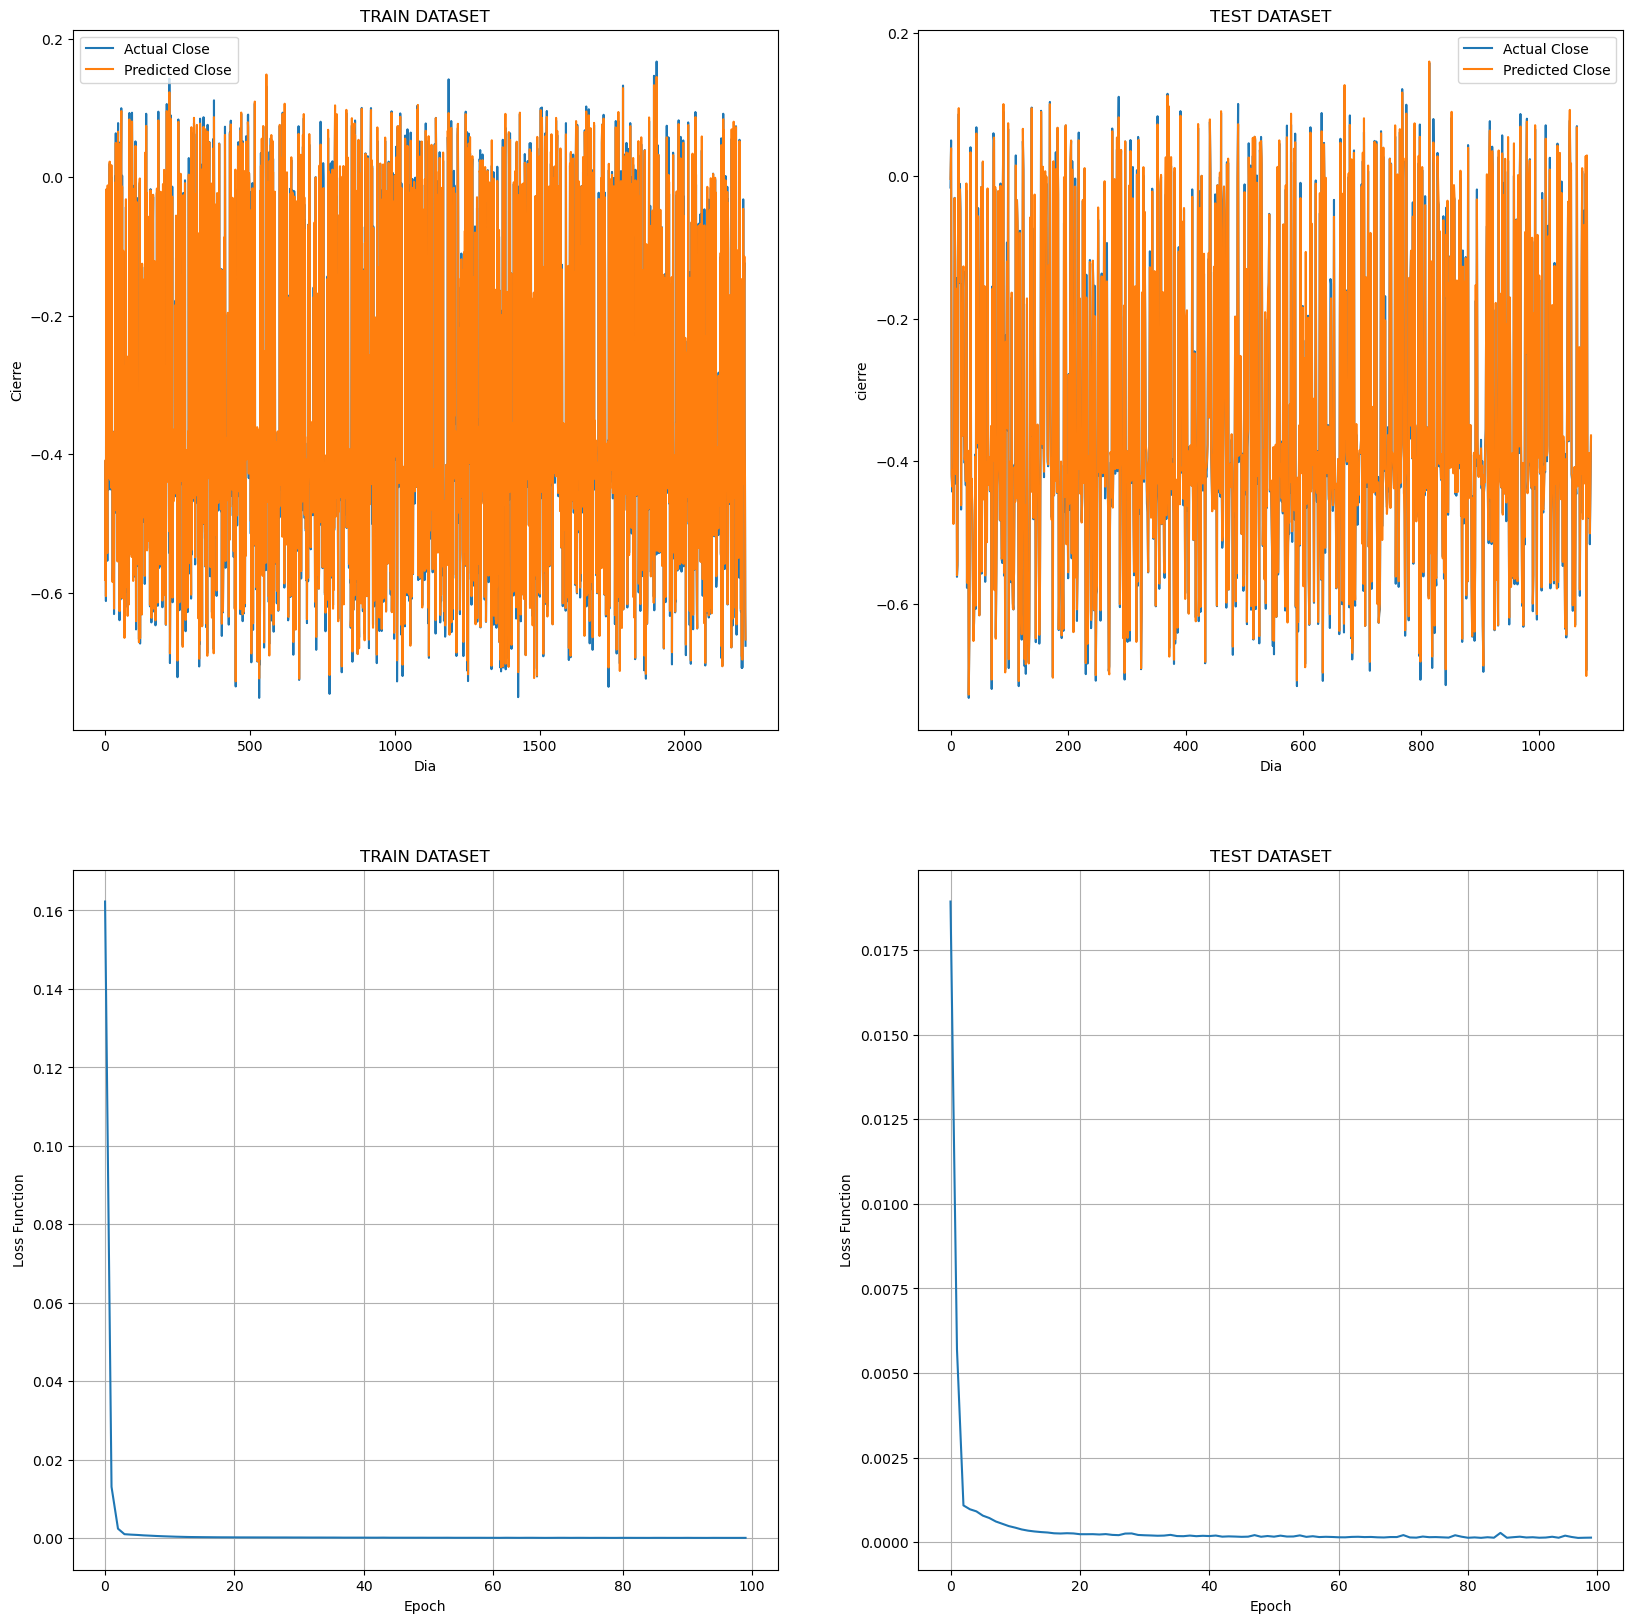

In [22]:
fig, ax = plt.subplots(2,2,figsize=(20,20))

with torch.no_grad():
    predicted_train=modelo(x_train).numpy()
with torch.no_grad():
    predicted_test=modelo(x_test).numpy()    
    
ax[0,0].plot(y_train, label='Actual Close')
ax[0,0].plot(predicted_train,label="Predicted Close")
ax[0,0].set_xlabel('Dia')
ax[0,0].set_ylabel('Cierre')
ax[0,0].legend()
ax[0,0].set_title("TRAIN DATASET")

ax[0,1].plot(y_test, label='Actual Close')
ax[0,1].plot(predicted_test,label="Predicted Close")
ax[0,1].set_xlabel('Dia')
ax[0,1].set_ylabel('cierre')
ax[0,1].legend()
ax[0,1].set_title("TEST DATASET")

ax[1,0].plot(train_loss)
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_ylabel('Loss Function')
ax[1,0].grid()
ax[1,0].set_title("TRAIN DATASET")

ax[1,1].plot(test_loss)
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_ylabel('Loss Function')
ax[1,1].grid()
ax[1,1].set_title("TEST DATASET")

plt.show()

In [23]:
np.mean((torch.abs((y_test - predicted_test)/y_test).numpy()<0.05))

0.7807339449541284

Text(0.5, 1.0, 'accuracy evolution')

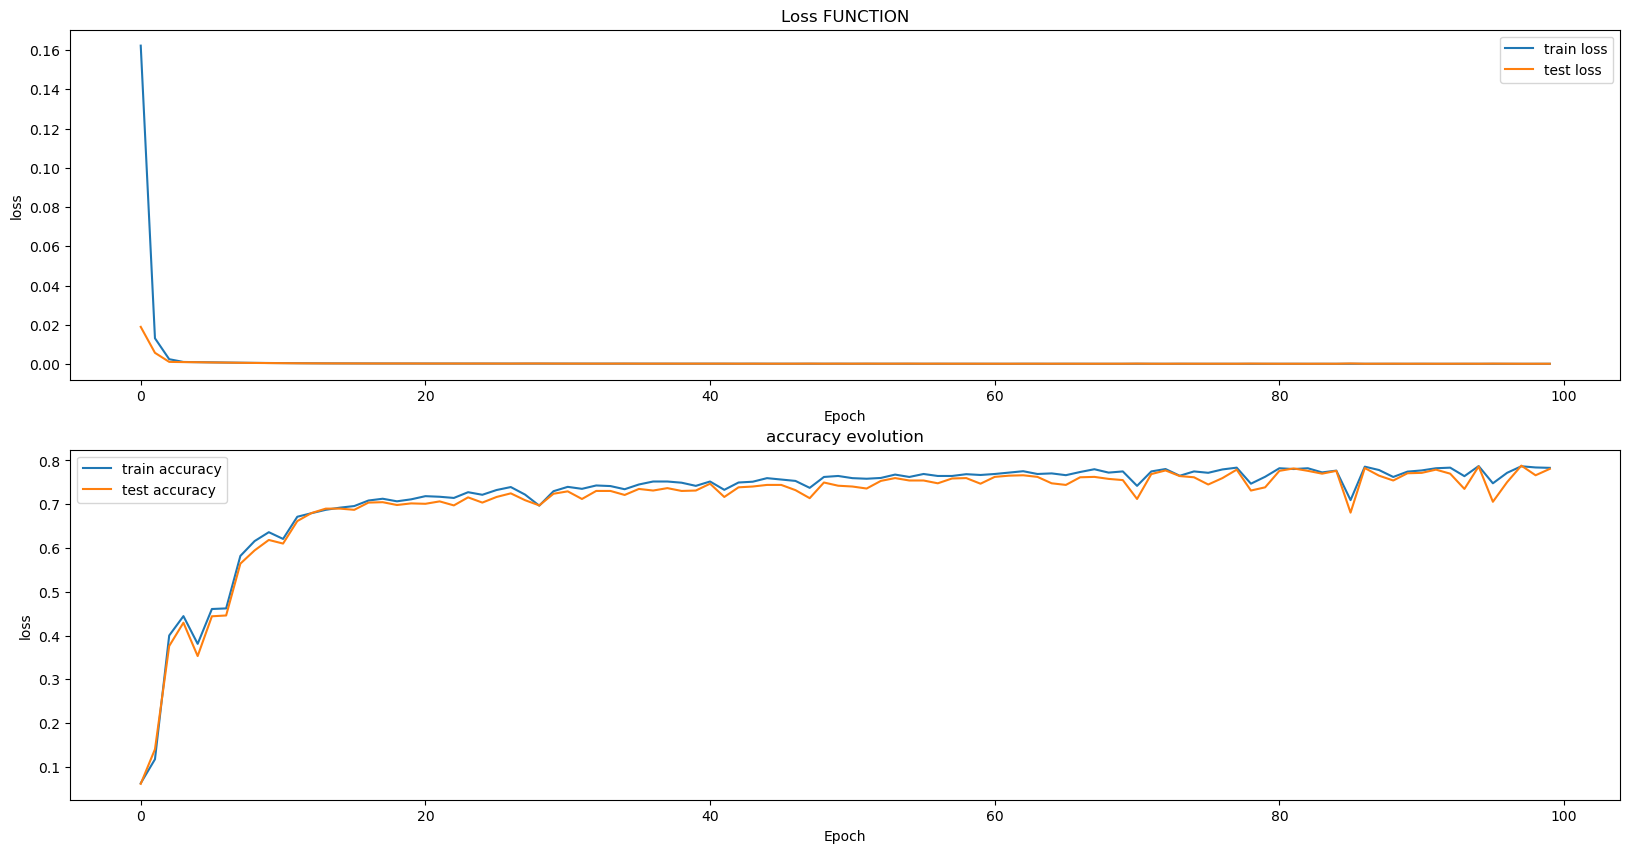

In [24]:
fig, ax = plt.subplots(2,1,figsize=(20,10))

ax[0].plot(train_loss, label='train loss')
ax[0].plot(test_loss,label="test loss")
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[0].set_title("Loss FUNCTION")

ax[1].plot(train_accuracy, label='train accuracy')
ax[1].plot(test_accuracy,label="test accuracy")
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('loss')
ax[1].legend()
ax[1].set_title("accuracy evolution")

## GRU

In [25]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.hidden_layer = nn.GRU(input_size, self.hidden_size, num_layers=1, batch_first=True)
        self.output_layer = nn.Linear(self.hidden_size, 1)
        self.tanh=nn.Tanh()
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(1, batch_size, self.hidden_size)
        out, h = self.hidden_layer(x, h0)
        output = self.tanh(self.output_layer(out[:, -1, :]))
        
        return output

In [26]:
modelo=GRU(input_size=1,hidden_size=10,output_size=1)

In [27]:
train_loss= []
test_loss=[]
test_accuracy=[]
train_accuracy=[]

In [28]:
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(modelo.parameters(), lr=learning_rate)

In [29]:
for epoch in range (num_epochs):
    train_loss.append(train_one_epoch())
    with torch.no_grad():
        predicted_train=modelo(x_train).numpy()
        train_accuracy.append(np.mean((torch.abs((y_train - predicted_train)/y_train).numpy()<0.05)))
    print("Train Loss: {0:.5f}".format(train_loss[-1]),end="\t")

    with torch.no_grad():
        predicted_test=modelo(x_test).numpy()
        test_accuracy.append(np.mean((torch.abs((y_test - predicted_test)/y_test).numpy()<0.05)))
    
    test_loss.append(validate_one_epoch())
    print("Val Loss: {0:.5f}".format(test_loss[-1]))


Epoch: 1
Train Loss: 0.03883	Val Loss: 0.02772
Epoch: 2
Train Loss: 0.01173	Val Loss: 0.00054
Epoch: 3
Train Loss: 0.00044	Val Loss: 0.00041
Epoch: 4
Train Loss: 0.00037	Val Loss: 0.00034
Epoch: 5
Train Loss: 0.00032	Val Loss: 0.00032
Epoch: 6
Train Loss: 0.00029	Val Loss: 0.00026
Epoch: 7
Train Loss: 0.00027	Val Loss: 0.00025
Epoch: 8
Train Loss: 0.00024	Val Loss: 0.00023
Epoch: 9
Train Loss: 0.00023	Val Loss: 0.00022
Epoch: 10
Train Loss: 0.00021	Val Loss: 0.00021
Epoch: 11
Train Loss: 0.00020	Val Loss: 0.00020
Epoch: 12
Train Loss: 0.00019	Val Loss: 0.00019
Epoch: 13
Train Loss: 0.00018	Val Loss: 0.00019
Epoch: 14
Train Loss: 0.00017	Val Loss: 0.00018
Epoch: 15
Train Loss: 0.00017	Val Loss: 0.00018
Epoch: 16
Train Loss: 0.00016	Val Loss: 0.00018
Epoch: 17
Train Loss: 0.00017	Val Loss: 0.00017
Epoch: 18
Train Loss: 0.00015	Val Loss: 0.00016
Epoch: 19
Train Loss: 0.00015	Val Loss: 0.00017
Epoch: 20
Train Loss: 0.00015	Val Loss: 0.00017
Epoch: 21
Train Loss: 0.00014	Val Loss: 0.00022
E

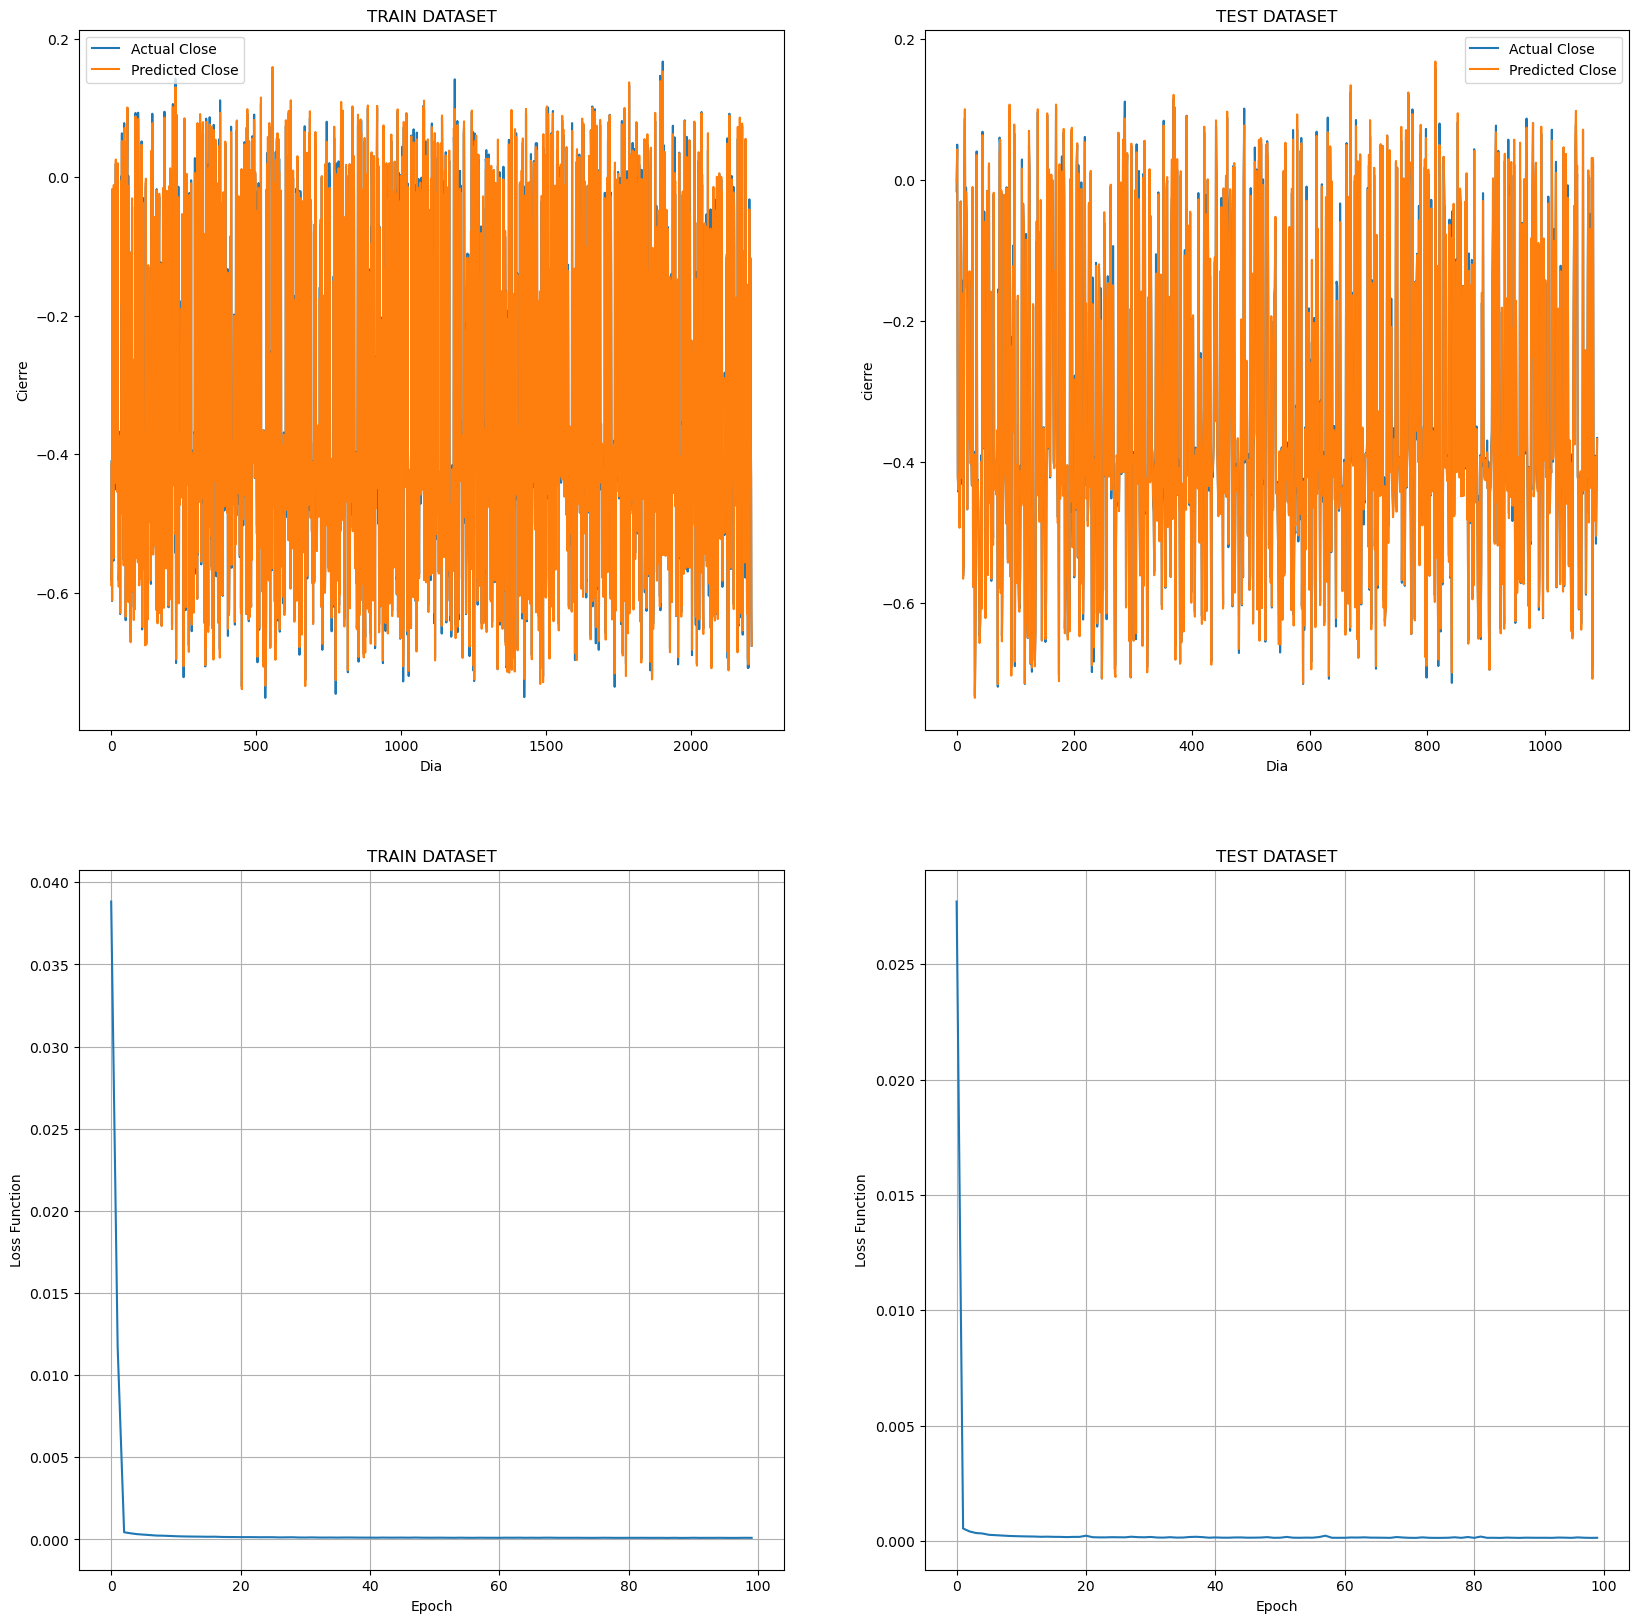

In [30]:
fig, ax = plt.subplots(2,2,figsize=(20,20))

    
ax[0,0].plot(y_train, label='Actual Close')
ax[0,0].plot(predicted_train,label="Predicted Close")
ax[0,0].set_xlabel('Dia')
ax[0,0].set_ylabel('Cierre')
ax[0,0].legend()
ax[0,0].set_title("TRAIN DATASET")

ax[0,1].plot(y_test, label='Actual Close')
ax[0,1].plot(predicted_test,label="Predicted Close")
ax[0,1].set_xlabel('Dia')
ax[0,1].set_ylabel('cierre')
ax[0,1].legend()
ax[0,1].set_title("TEST DATASET")

ax[1,0].plot(train_loss)
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_ylabel('Loss Function')
ax[1,0].grid()
ax[1,0].set_title("TRAIN DATASET")

ax[1,1].plot(test_loss)
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_ylabel('Loss Function')
ax[1,1].grid()
ax[1,1].set_title("TEST DATASET")


plt.show()

In [31]:
np.mean((torch.abs((y_test - predicted_test)/y_test).numpy()<0.05))

0.7834862385321101

Text(0.5, 1.0, 'accuracy evolution')

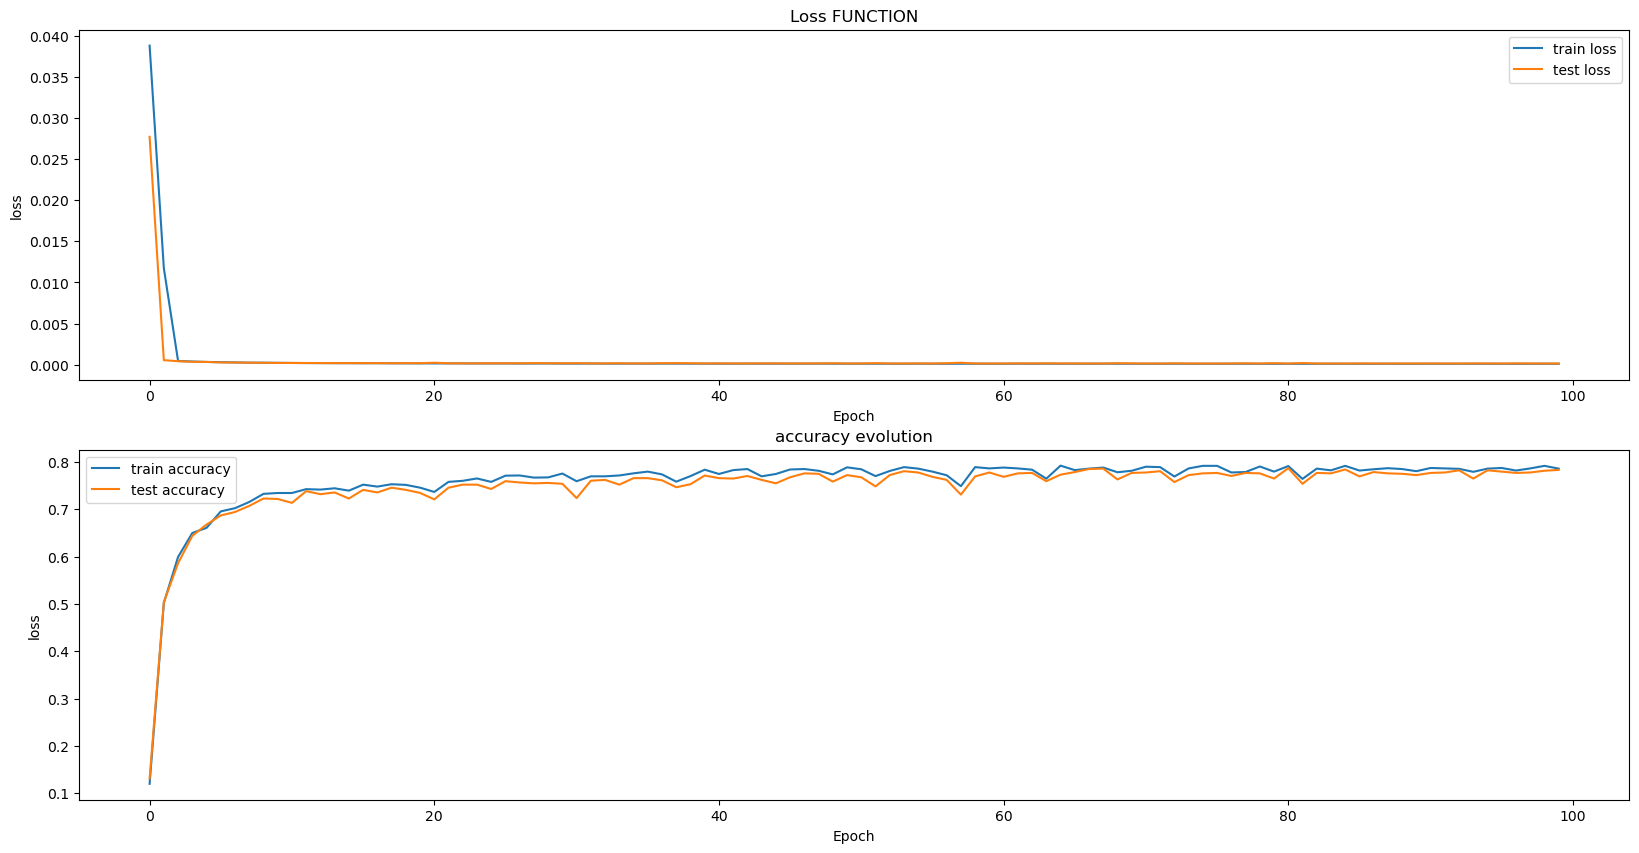

In [32]:
fig, ax = plt.subplots(2,1,figsize=(20,10))

ax[0].plot(train_loss, label='train loss')
ax[0].plot(test_loss,label="test loss")
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[0].set_title("Loss FUNCTION")

ax[1].plot(train_accuracy, label='train accuracy')
ax[1].plot(test_accuracy,label="test accuracy")
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('loss')
ax[1].legend()
ax[1].set_title("accuracy evolution")

## LSTM

In [33]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size=input_size
        self.output_size=output_size
        self.hidden_layer = nn.LSTM(input_size, self.hidden_size, num_layers=1, batch_first=True)
        self.output_layer = nn.Linear(self.hidden_size, self.output_size)
        self.tanh=nn.Tanh()
        
        
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(1, batch_size, self.hidden_size)
        c0 = torch.zeros(1, batch_size, self.hidden_size)
        out, (h, c) = self.hidden_layer(x, (h0,c0))
        output = self.tanh(self.output_layer(out[:, -1, :]))
        return output

In [34]:
modelo=LSTM(input_size=1,hidden_size=10,output_size=1)

In [35]:
train_loss= []
test_loss=[]
test_accuracy=[]
train_accuracy=[]

In [36]:
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(modelo.parameters(), lr=learning_rate)

In [37]:
for epoch in range (num_epochs):
    train_loss.append(train_one_epoch())
    with torch.no_grad():
        predicted_train=modelo(x_train).numpy()
        train_accuracy.append(np.mean((torch.abs((y_train - predicted_train)/y_train).numpy()<0.05)))
    print("Train Loss: {0:.5f}".format(train_loss[-1]),end="\t")

    with torch.no_grad():
        predicted_test=modelo(x_test).numpy()
        test_accuracy.append(np.mean((torch.abs((y_test - predicted_test)/y_test).numpy()<0.05)))
    
    test_loss.append(validate_one_epoch())
    print("Val Loss: {0:.5f}".format(test_loss[-1]))

Epoch: 1
Train Loss: 0.04823	Val Loss: 0.01417
Epoch: 2
Train Loss: 0.00260	Val Loss: 0.00077
Epoch: 3
Train Loss: 0.00071	Val Loss: 0.00059
Epoch: 4
Train Loss: 0.00058	Val Loss: 0.00048
Epoch: 5
Train Loss: 0.00048	Val Loss: 0.00045
Epoch: 6
Train Loss: 0.00043	Val Loss: 0.00043
Epoch: 7
Train Loss: 0.00038	Val Loss: 0.00034
Epoch: 8
Train Loss: 0.00034	Val Loss: 0.00032
Epoch: 9
Train Loss: 0.00033	Val Loss: 0.00032
Epoch: 10
Train Loss: 0.00031	Val Loss: 0.00030
Epoch: 11
Train Loss: 0.00029	Val Loss: 0.00029
Epoch: 12
Train Loss: 0.00028	Val Loss: 0.00032
Epoch: 13
Train Loss: 0.00028	Val Loss: 0.00027
Epoch: 14
Train Loss: 0.00026	Val Loss: 0.00027
Epoch: 15
Train Loss: 0.00025	Val Loss: 0.00025
Epoch: 16
Train Loss: 0.00025	Val Loss: 0.00028
Epoch: 17
Train Loss: 0.00024	Val Loss: 0.00025
Epoch: 18
Train Loss: 0.00024	Val Loss: 0.00028
Epoch: 19
Train Loss: 0.00022	Val Loss: 0.00023
Epoch: 20
Train Loss: 0.00022	Val Loss: 0.00022
Epoch: 21
Train Loss: 0.00021	Val Loss: 0.00030
E

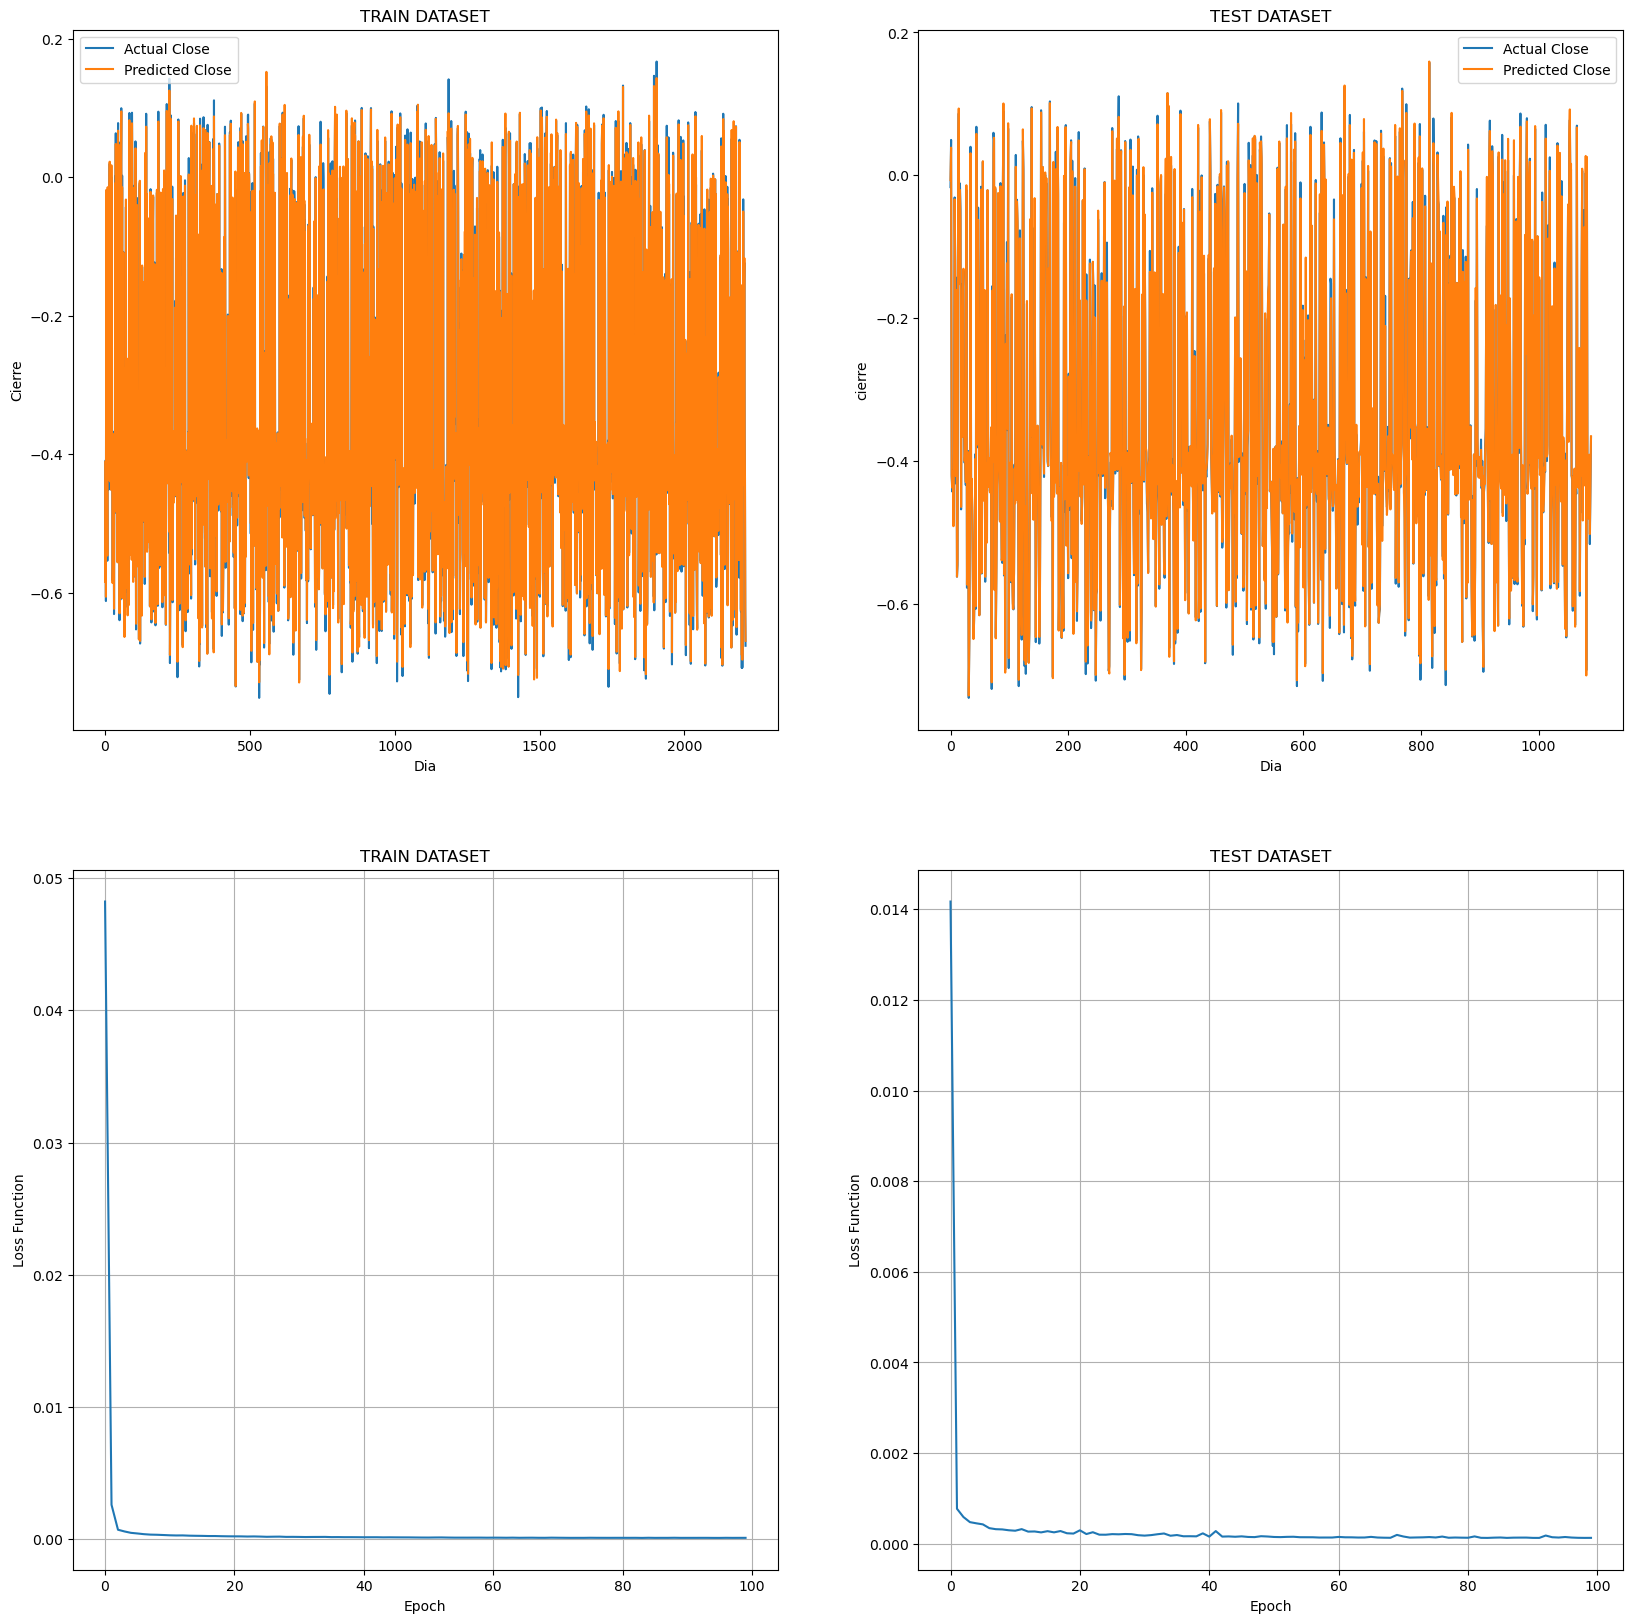

In [38]:
fig, ax = plt.subplots(2,2,figsize=(20,20))

    
ax[0,0].plot(y_train, label='Actual Close')
ax[0,0].plot(predicted_train,label="Predicted Close")
ax[0,0].set_xlabel('Dia')
ax[0,0].set_ylabel('Cierre')
ax[0,0].legend()
ax[0,0].set_title("TRAIN DATASET")

ax[0,1].plot(y_test, label='Actual Close')
ax[0,1].plot(predicted_test,label="Predicted Close")
ax[0,1].set_xlabel('Dia')
ax[0,1].set_ylabel('cierre')
ax[0,1].legend()
ax[0,1].set_title("TEST DATASET")

ax[1,0].plot(train_loss)
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_ylabel('Loss Function')
ax[1,0].grid()
ax[1,0].set_title("TRAIN DATASET")

ax[1,1].plot(test_loss)
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_ylabel('Loss Function')
ax[1,1].grid()
ax[1,1].set_title("TEST DATASET")


plt.show()

In [39]:
np.mean((torch.abs((y_test - predicted_test)/y_test).numpy()<0.05))

0.773394495412844

Text(0.5, 1.0, 'accuracy evolution')

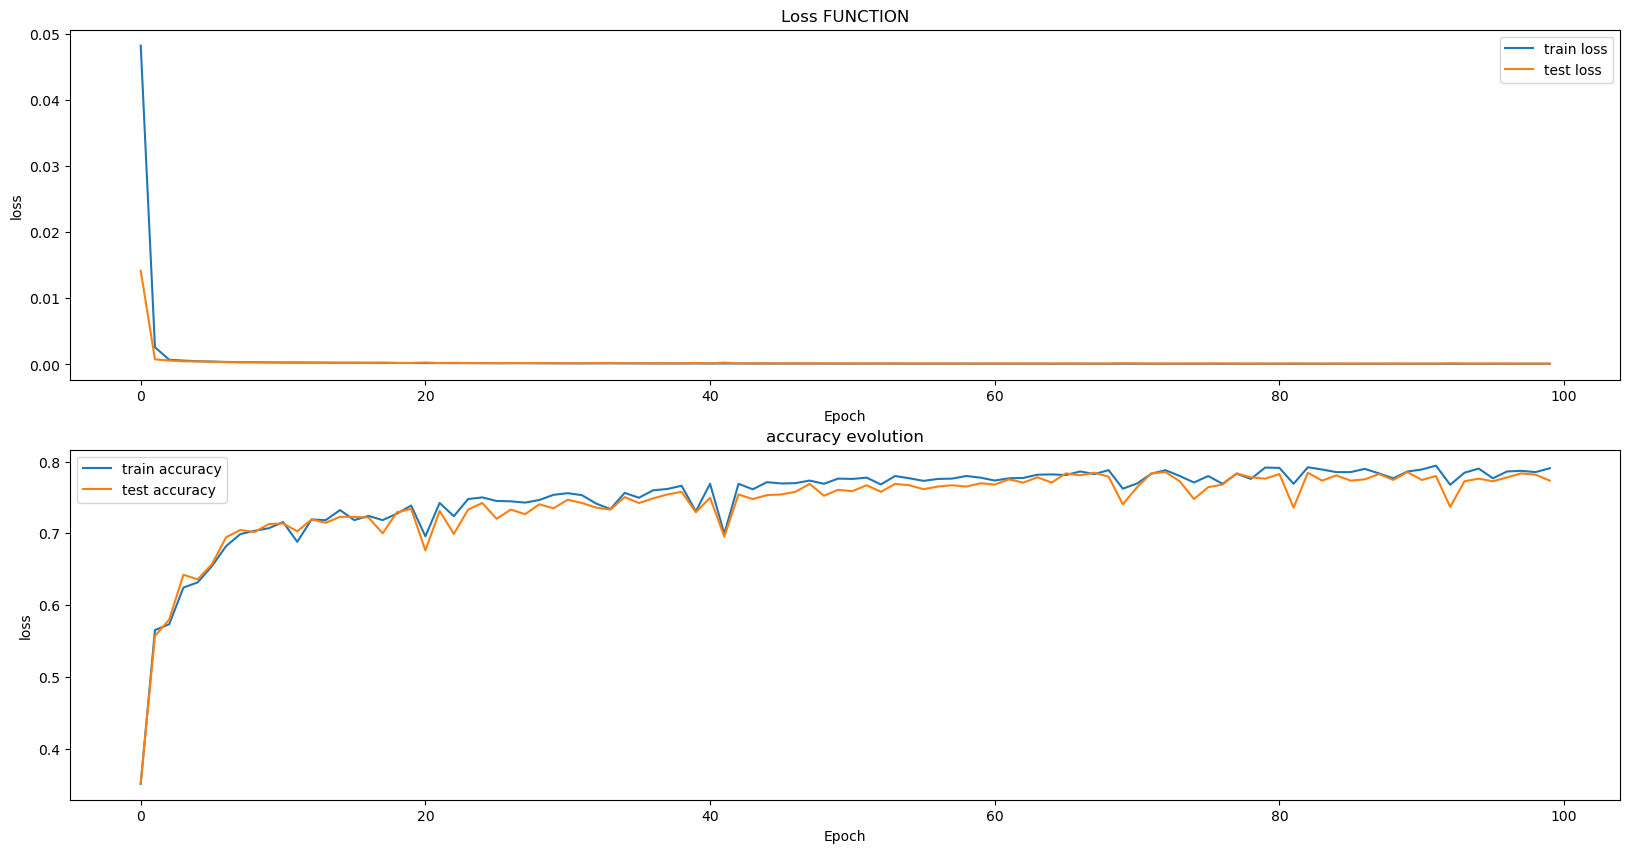

In [40]:
fig, ax = plt.subplots(2,1,figsize=(20,10))

ax[0].plot(train_loss, label='train loss')
ax[0].plot(test_loss,label="test loss")
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[0].set_title("Loss FUNCTION")

ax[1].plot(train_accuracy, label='train accuracy')
ax[1].plot(test_accuracy,label="test accuracy")
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('loss')
ax[1].legend()
ax[1].set_title("accuracy evolution")